<a href="https://colab.research.google.com/github/realBagher/AI-for-Medicine-Specialization/blob/main/classification/multi_classclassification_stackoverflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf 
import matplotlib.pyplot as plt
 
import os
import re
import shutil 
import string 


In [2]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'


dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'stack')

6053168/6053168 [==============================] - 0s 0us/step


In [5]:
os.listdir(dataset_dir)

['test', 'train']

In [6]:
tf.keras.utils.text_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='int',
    class_names=None,
    batch_size=32,
    max_length=None,
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    follow_links=False
)

Found 16000 files belonging to 2 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'stack/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    shuffle=False,
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"how to pause loop while time is ticking i have made a timer where i can set time i want to wait and then do something..so this is my short timer func:..private void sleep(int interval, action action).{.    system.windows.forms.timer mytimer = new system.windows.forms.timer();.    mytimer.interval = interval; //interval is in ms   .    mytimer.start();.    mytimer.tick += (s, e) =&gt;.    {.        action();.        mytimer.stop();.    };.}...and im using this timer in loop:..foreach (string word in words).{.   sleep(5000, ()=&gt; myaction());                                           .}...without loop timer is great but in loop it wont work because loop wont stop and wait for those 5secs. it do all stuff imediately and starts timer again and again too fast...so what im trying to find out is how to make my loop wait until time runs out and myaction() is executed. im working on forms application so all threadin sleeps wont work here. also i tried all other timers but they used 

In [9]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to csharp
Label 1 corresponds to java


In [10]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'stack/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    shuffle=False,
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [11]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'stack/test', 
    batch_size=batch_size, 
    shuffle=False,
    seed=seed)

Found 8000 files belonging to 4 classes.


In [12]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [13]:
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [14]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [15]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [16]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"how to pause loop while time is ticking i have made a timer where i can set time i want to wait and then do something..so this is my short timer func:..private void sleep(int interval, action action).{.    system.windows.forms.timer mytimer = new system.windows.forms.timer();.    mytimer.interval = interval; //interval is in ms   .    mytimer.start();.    mytimer.tick += (s, e) =&gt;.    {.        action();.        mytimer.stop();.    };.}...and im using this timer in loop:..foreach (string word in words).{.   sleep(5000, ()=&gt; myaction());                                           .}...without loop timer is great but in loop it wont work because loop wont stop and wait for those 5secs. it do all stuff imediately and starts timer again and again too fast...so what im trying to find out is how to make my loop wait until time runs out and myaction() is executed. im working on forms application so all threadin sleeps wont work here. also i tried all other timers but 

In [17]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
embedding_dim = 16

In [20]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(max_features + 1, embedding_dim),
   tf.keras.layers.Dropout(0.2),
   tf.keras.layers.GlobalAveragePooling1D(),
   tf.keras.layers.Dropout(0.2),
   tf.keras.layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [27]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.CategoricalAccuracy())

In [28]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 [==============================] - 3s 12ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 2/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 6/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0

In [29]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Loss:  0.0
Accuracy:  1.0


In [30]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

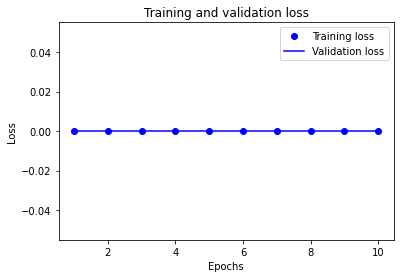

In [32]:
acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

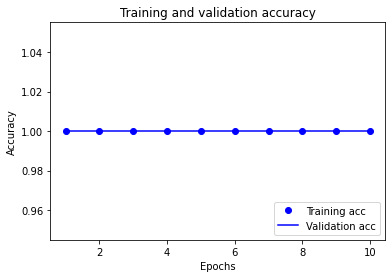

In [33]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [35]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  tf.keras.layers.Activation('softmax')
])

export_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 2s 6ms/step - loss: 0.0000e+00 - accuracy: 0.2500
0.25


In [ ]:
example = ["Review b'how to pause loop while time is ticking i have made a timer where i can set time i want to wait and then do something..so this is my short timer func:..private void sleep(int interval, action action).{.    system.windows.forms.timer mytimer = new system.windows.forms.timer();.    mytimer.interval = interval; //interval is in ms   .    mytimer.start();.    mytimer.tick += (s, e) =&gt;.    {.        action();.        mytimer.stop();.    };.}...and im using this timer in loop:..foreach (string word in words).{.   sleep(5000, ()=&gt; myaction());                                           .}...without loop timer is great but in loop it wont work because loop wont stop and wait for those 5secs. it do all stuff imediately and starts timer again and again too fast...so what im trying to find out is how to make my loop wait until time runs out and myaction() is executed. im working on forms application so all threadin sleeps wont work here. also i tried all other timers but they used too much cpu.
"]